# Data Wrangling and SQL Pacmann

## 1. Analysis Objective
1. Top 5 products category by orders.  
2. Top 5 products category by revenue.
3. Sales trends based on time period.  
4. Total order by payment method.    
5. Distribution of review scores.  

### Import neccessary module

In [1]:
# Import module to connect to db.
import sqlite3

# Import module to manipulate db.
import pandas as pd
import numpy as np
import datetime as dt

# Import module to visualize output.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## 2. Data Overview

### Load database into notebook

In [2]:
# Connect to db.
db_connect = sqlite3.connect('olist.db')

# Show db table.
df = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", db_connect)
df

,name
0,olist_order_customer_dataset
1,olist_order_dataset
2,olist_order_reviews_dataset
3,olist_order_payments_dataset
4,olist_order_items_dataset
5,olist_products_dataset
6,olist_sellers_dataset
7,olist_geolocation_dataset
8,product_category_name_translation


## 3. Data Pre-Processing

### Define prerequisite variable as a dataset from database

In [3]:
# Define customer dataset variable.
customer = pd.read_sql_query(
    """
    SELECT *
    FROM olist_order_customer_dataset;
    """, db_connect)

# Define order dataset variable.
order = pd.read_sql_query(
    """
    SELECT * 
    FROM olist_order_dataset;
    """, db_connect)

# Define order reviews dataset variable.
review = pd.read_sql_query(
    """
    SELECT * 
    FROM olist_order_reviews_dataset;
    """, db_connect)

# Define order payments dataset variable.
payment = pd.read_sql_query(
    """
    SELECT * 
    FROM olist_order_payments_dataset;
    """, db_connect)
    
# Define order items dataset variable.
item = pd.read_sql_query(
    """
    SELECT *
    FROM olist_order_items_dataset;
    """, db_connect)
    
# Define category name translation dataset variable.
category = pd.read_sql_query(
    """
    SELECT *
    FROM product_category_name_translation;
    """, db_connect)

# Define products dataset variable.
product = pd.read_sql_query(
    """
    SELECT *
    FROM olist_products_dataset;
    """, db_connect)

# Define sellers dataset variable.
seller = pd.read_sql_query(
    """
    SELECT *
    FROM olist_sellers_dataset;
    """, db_connect)

# Define geolocation dataset variable.
geolocation = pd.read_sql_query(
    """
    SELECT *
    FROM olist_geolocation_dataset;
    """, db_connect)

### Perform data manipulation using pandas dataframe

In [4]:
# Merge all tables into one using pandas DataFrame.
df = pd.merge(order, item, on='order_id', how='left')
df = pd.merge(df, product, on='product_id', how='inner')
df = pd.merge(df, payment, on='order_id', how='left', suffixes=('_payment', '_order'))
df = pd.merge(df, review, on='order_id', how='left', suffixes=('_review', '_order'))
df = pd.merge(df, customer, on='customer_id', how='right', suffixes=('_customer', '_order'))
df = pd.merge(df, category, on='product_category_name', suffixes=('_category', '_product'))

### Show dataset information we are working on

In [5]:
# Define variable for rows and columns value.
row, col = df.shape

print(f"Total columns: {col}")
print(f"Total rows: {row}")

Total columns: 44
Total rows: 116576


In [6]:
# Show dataset information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116576 entries, 0 to 116575
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_x                        116576 non-null  float64
 1   order_id                       116576 non-null  object 
 2   customer_id                    116576 non-null  object 
 3   order_status                   116576 non-null  object 
 4   order_purchase_timestamp       116576 non-null  object 
 5   order_approved_at              116562 non-null  object 
 6   order_delivered_carrier_date   115363 non-null  object 
 7   order_delivered_customer_date  114061 non-null  object 
 8   order_estimated_delivery_date  116576 non-null  object 
 9   index_y                        116576 non-null  float64
 10  order_item_id                  116576 non-null  float64
 11  product_id                     116576 non-null  object 
 12  seller_id                     

### Perform data cleaning to remove unnecessary data

In [7]:
# Remove columns that are not required for analysis.
df = df.drop(columns=['index','index_x','index_y',
                      'index_payment','index_customer','index_order',
                      'shipping_limit_date','product_category_name','product_name_lenght', 
                      'product_description_lenght','order_delivered_carrier_date','product_weight_g',
                      'product_length_cm','product_height_cm','product_width_cm',
                      'payment_installments','order_delivered_customer_date', 'review_id', 
                      'review_comment_title','review_comment_message','review_creation_date',
                      'review_answer_timestamp','customer_id','order_approved_at',
                      'order_item_id']) 

# Show current state of dataset.
df.head()

,order_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,price,freight_value,product_photos_qty,payment_sequential,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-06-05 00:00:00,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1.0,1.0,credit_card,146.87,4.0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,office_furniture
1,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-13 00:00:00,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1.0,1.0,credit_card,157.73,5.0,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,office_furniture
2,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-04-10 00:00:00,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1.0,1.0,credit_card,173.30,5.0,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,office_furniture
3,997fd4b37386d10b57d4ac8cdec011a6,delivered,2018-07-08 09:59:19,2018-08-16 00:00:00,8ed094bfe076c568f6bb10feada3f75d,7c67e1448b00f6e969d365cea6b010ab,199.98,115.77,1.0,1.0,credit_card,315.75,1.0,07d190f123147d9e89d4b922543d7948,65075,sao luis,MA,office_furniture
4,b63fff1ef8b6201df68bb611ee41129e,delivered,2017-04-02 22:15:27,2017-05-08 00:00:00,aba86c093ccdbac75b09111d57e50004,7c67e1448b00f6e969d365cea6b010ab,129.60,16.61,1.0,1.0,boleto,146.21,4.0,332cf4e83e16004ba7dca932ce82475b,90010,porto alegre,RS,office_furniture


In [8]:
# Rename product category name column,
# since we dropped the original one.
df = df.rename(columns={"product_category_name_english": "product_category_name"})

In [9]:
# Identify duplicate rows in the DataFrame.
df[df.duplicated(keep=False)]

,order_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,price,freight_value,product_photos_qty,payment_sequential,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name
8,c43d312cae83cf5e4a99152bf27be2ee,delivered,2017-07-28 20:25:12,2017-08-25 00:00:00,e8316a4667e5870c85e906b1f062bde1,7c67e1448b00f6e969d365cea6b010ab,90.99,28.00,1.0,1.0,credit_card,237.98,5.0,c1c7632732a487b1221e7bfb627c575f,24220,niteroi,RJ,office_furniture
9,c43d312cae83cf5e4a99152bf27be2ee,delivered,2017-07-28 20:25:12,2017-08-25 00:00:00,e8316a4667e5870c85e906b1f062bde1,7c67e1448b00f6e969d365cea6b010ab,90.99,28.00,1.0,1.0,credit_card,237.98,5.0,c1c7632732a487b1221e7bfb627c575f,24220,niteroi,RJ,office_furniture
14,cee3d35c01c3ae1ed31809bdb2272afb,delivered,2017-07-24 22:26:44,2017-08-17 00:00:00,6f842ad54a86bf94d9254744d910ec56,7c67e1448b00f6e969d365cea6b010ab,79.99,24.87,1.0,1.0,boleto,419.44,5.0,d36fc675519adcbd1e824cabc25bda07,15010,sao jose do rio preto,SP,office_furniture
15,cee3d35c01c3ae1ed31809bdb2272afb,delivered,2017-07-24 22:26:44,2017-08-17 00:00:00,6f842ad54a86bf94d9254744d910ec56,7c67e1448b00f6e969d365cea6b010ab,79.99,24.87,1.0,1.0,boleto,419.44,5.0,d36fc675519adcbd1e824cabc25bda07,15010,sao jose do rio preto,SP,office_furniture
16,cee3d35c01c3ae1ed31809bdb2272afb,delivered,2017-07-24 22:26:44,2017-08-17 00:00:00,6f842ad54a86bf94d9254744d910ec56,7c67e1448b00f6e969d365cea6b010ab,79.99,24.87,1.0,1.0,boleto,419.44,5.0,d36fc675519adcbd1e824cabc25bda07,15010,sao jose do rio preto,SP,office_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116528,3ed26cafd58917f71e9044701fe9e7cb,delivered,2017-08-31 18:54:14,2017-09-19 00:00:00,ec5b3c8bb77ad22278f6e9d719a83de3,4a3ca9315b744ce9f8e9374361493884,12.90,11.85,1.0,1.0,credit_card,49.50,5.0,6f1b52490e2f1dfbb7cd7309230dbb36,5021,sao paulo,SP,home_comfort_2
116529,3ed26cafd58917f71e9044701fe9e7cb,delivered,2017-08-31 18:54:14,2017-09-19 00:00:00,ec5b3c8bb77ad22278f6e9d719a83de3,4a3ca9315b744ce9f8e9374361493884,12.90,11.85,1.0,1.0,credit_card,49.50,5.0,6f1b52490e2f1dfbb7cd7309230dbb36,5021,sao paulo,SP,home_comfort_2
116535,688c77c72e79654a39228923333fc18f,delivered,2017-10-28 07:10:49,2017-11-21 00:00:00,ec5b3c8bb77ad22278f6e9d719a83de3,4a3ca9315b744ce9f8e9374361493884,12.90,15.10,1.0,1.0,credit_card,84.00,NaN,09fe8ab1462ab9578e8b5ca1bcf63947,22783,rio de janeiro,RJ,home_comfort_2
116536,688c77c72e79654a39228923333fc18f,delivered,2017-10-28 07:10:49,2017-11-21 00:00:00,ec5b3c8bb77ad22278f6e9d719a83de3,4a3ca9315b744ce9f8e9374361493884,12.90,15.10,1.0,1.0,credit_card,84.00,NaN,09fe8ab1462ab9578e8b5ca1bcf63947,22783,rio de janeiro,RJ,home_comfort_2


In [10]:
# Filter and create a pandas Series 'nan_col'
# that includes only columns with at least one missing value.
missing_col = df.isnull().sum()[df.isnull().sum() > 0]

# Create a DataFrame consists of 
# NaN count column and NaN percentage column
missing_col_df = pd.DataFrame({'NaN_count': missing_col, 'NaN_percentage': missing_col / len(df) * 100}).sort_values(by = 'NaN_percentage', ascending = False)

# Show missing values information.
missing_col_df

,NaN_count,NaN_percentage
review_score,964,0.826928
payment_sequential,3,0.002573
payment_type,3,0.002573
payment_value,3,0.002573


In [11]:
# Check missing value on payment type column.
df[df['payment_type'].isnull()]

,order_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,price,freight_value,product_photos_qty,payment_sequential,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name
51502,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-10-04 00:00:00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,1.0,NaN,NaN,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,health_beauty
51503,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-10-04 00:00:00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,1.0,NaN,NaN,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,health_beauty
51504,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-10-04 00:00:00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,1.0,NaN,NaN,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,health_beauty


In [12]:
# Drop rows with missing value on 'payment_type' column.
df.dropna(subset=['payment_type'], inplace = True)

In [13]:
# Find the mode (most frequent value) of the 'review_score' column 
mode_rev_score = df['review_score'].mode()[0]

# then fills any missing values in that column with this mode value.
df['review_score'].fillna(mode_rev_score, inplace=True)

In [14]:
# Recheck whether there are missing values.
df.isna().sum()

order_id                         0
order_status                     0
order_purchase_timestamp         0
order_estimated_delivery_date    0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
product_photos_qty               0
payment_sequential               0
payment_type                     0
payment_value                    0
review_score                     0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
product_category_name            0
dtype: int64

In [15]:
# Check current state of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116573 entries, 0 to 116575
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116573 non-null  object 
 1   order_status                   116573 non-null  object 
 2   order_purchase_timestamp       116573 non-null  object 
 3   order_estimated_delivery_date  116573 non-null  object 
 4   product_id                     116573 non-null  object 
 5   seller_id                      116573 non-null  object 
 6   price                          116573 non-null  float64
 7   freight_value                  116573 non-null  float64
 8   product_photos_qty             116573 non-null  float64
 9   payment_sequential             116573 non-null  float64
 10  payment_type                   116573 non-null  object 
 11  payment_value                  116573 non-null  float64
 12  review_score                  

### Perform data manipulation to set appropriate data type

In [16]:
# Change order purchase timestamp data type to date and time data type.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], yearfirst=True)

# Extract date and time from order purchase timestamp.
df['year'] = df['order_purchase_timestamp'].dt.year
df['month'] = df['order_purchase_timestamp'].dt.month
df['date'] = df['order_purchase_timestamp'].dt.day

In [17]:
# Alter the data type of particular columns.
set_type = {'product_photos_qty': int,
            'payment_sequential' : int, 
            'review_score' : int, 
            'customer_zip_code_prefix' : str
            }

# Apply data manipulation
df = df.astype(set_type)
print(df.dtypes)

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_estimated_delivery_date            object
product_id                               object
seller_id                                object
price                                   float64
freight_value                           float64
product_photos_qty                        int32
payment_sequential                        int32
payment_type                             object
payment_value                           float64
review_score                              int32
customer_unique_id                       object
customer_zip_code_prefix                 object
customer_city                            object
customer_state                           object
product_category_name                    object
year                                      int64
month                                     int64
date                                    

In [18]:
# Check current state of dataset
df.head()

,order_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,price,freight_value,product_photos_qty,payment_sequential,...,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,year,month,date
0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-06-05 00:00:00,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,1,1,...,146.87,4,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,office_furniture,2017,5,16
1,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-13 00:00:00,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,139.94,17.79,1,1,...,157.73,5,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,office_furniture,2018,5,19
2,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-04-10 00:00:00,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,149.94,23.36,1,1,...,173.30,5,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,office_furniture,2018,3,13
3,997fd4b37386d10b57d4ac8cdec011a6,delivered,2018-07-08 09:59:19,2018-08-16 00:00:00,8ed094bfe076c568f6bb10feada3f75d,7c67e1448b00f6e969d365cea6b010ab,199.98,115.77,1,1,...,315.75,1,07d190f123147d9e89d4b922543d7948,65075,sao luis,MA,office_furniture,2018,7,8
4,b63fff1ef8b6201df68bb611ee41129e,delivered,2017-04-02 22:15:27,2017-05-08 00:00:00,aba86c093ccdbac75b09111d57e50004,7c67e1448b00f6e969d365cea6b010ab,129.60,16.61,1,1,...,146.21,4,332cf4e83e16004ba7dca932ce82475b,90010,porto alegre,RS,office_furniture,2017,4,2


### Perform data manipulation to remove duplicated data

In [19]:
# Identify duplicated rows.
df.duplicated().sum()

10881

In [20]:
# Shows the duplicated values to find out the cause.
df[df.duplicated()].sort_values('order_purchase_timestamp')

,order_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,product_id,seller_id,price,freight_value,product_photos_qty,payment_sequential,...,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,year,month,date
39406,36989eb07a0de2d3d3129eea35553875,delivered,2016-10-04 13:11:29,2016-12-06 00:00:00,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,23.90,26.82,2,1,...,101.44,5,f176923a0a4ab546c7287791ccb82193,78075,cuiaba,MT,furniture_decor,2016,10,4
28653,cb29497c3782a76b57327c055d58b0e0,delivered,2016-10-04 16:41:59,2016-11-28 00:00:00,8adc1d29aa4fd4d758a91ef997c8a0a2,b2ba3715d723d245138f291a6fe42594,64.90,16.70,1,1,...,163.20,1,2e15add79c76241beffe812a24ad3a31,22745,rio de janeiro,RJ,toys,2016,10,4
33420,cfdc6f2061897ed3b3f1a9ac3437c6f9,delivered,2016-10-04 22:03:46,2016-11-28 00:00:00,201ec8e4fb8456dd06265be68eb419a7,5a8e7d5003a1f221f9e1d6e411de7c23,59.90,14.83,2,1,...,149.46,3,e37af39d93f352f64ede45a151161d0c,21215,rio de janeiro,RJ,furniture_decor,2016,10,4
44470,dd11631d8b02780b78bd97ec44a1ca8c,delivered,2016-10-04 23:08:08,2016-11-28 00:00:00,27051f70cfcbd63fec388f34e1f0d2a2,ed859002ad59dbf8cf3602696a6c3000,149.90,19.33,1,1,...,338.46,5,d09bda44c78bc7eee6ab6a5814d73461,13480,limeira,SP,air_conditioning,2016,10,4
114333,ad1aeeb1a99c9f021e38a49865bb812c,delivered,2016-10-05 12:41:38,2016-12-09 00:00:00,d9894482fba41f536a273ba2276d951f,024b564ae893ce8e9bfa02c10a401ece,77.90,26.30,2,1,...,625.20,5,5f61b10d70849d46be5643b7453e1708,65065,sao luis,MA,market_place,2016,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58376,bee12e8653a04e76786e8891cfb6330a,delivered,2018-08-29 08:46:11,2018-09-11 00:00:00,8d4dac6177fb8134f26fb4c5cc6c0aff,c70c1b0d8ca86052f45a432a38b73958,91.55,7.90,1,1,...,497.25,5,afbcfd0b9c5233e7ccc73428526fbb52,12243,sao jose dos campos,SP,health_beauty,2018,8,29
58375,bee12e8653a04e76786e8891cfb6330a,delivered,2018-08-29 08:46:11,2018-09-11 00:00:00,8d4dac6177fb8134f26fb4c5cc6c0aff,c70c1b0d8ca86052f45a432a38b73958,91.55,7.90,1,1,...,497.25,5,afbcfd0b9c5233e7ccc73428526fbb52,12243,sao jose dos campos,SP,health_beauty,2018,8,29
58373,bee12e8653a04e76786e8891cfb6330a,delivered,2018-08-29 08:46:11,2018-09-11 00:00:00,8d4dac6177fb8134f26fb4c5cc6c0aff,c70c1b0d8ca86052f45a432a38b73958,91.55,7.90,1,1,...,497.25,5,afbcfd0b9c5233e7ccc73428526fbb52,12243,sao jose dos campos,SP,health_beauty,2018,8,29
58374,bee12e8653a04e76786e8891cfb6330a,delivered,2018-08-29 08:46:11,2018-09-11 00:00:00,8d4dac6177fb8134f26fb4c5cc6c0aff,c70c1b0d8ca86052f45a432a38b73958,91.55,7.90,1,1,...,497.25,5,afbcfd0b9c5233e7ccc73428526fbb52,12243,sao jose dos campos,SP,health_beauty,2018,8,29


In [21]:
# Remove all the duplicated rows from the DataFrame.
df.drop_duplicates(inplace=True)  

In [22]:
# Recheck whether there are duplicated values.
df.duplicated().sum()

0

### Perform data manipulation to remove inconsistent column value with the same meaning

In [23]:
# Verify discrepancies in values for each categorical data.
product_category = ['order_status', 'payment_type', 'customer_city', 'customer_state', 'product_category_name']

# Print each column's unique values with a header 
# indicating the column name for clarity.
for i in product_category:
  print(f"Unique Value from {i}:")
  print(sorted(df[i].unique()))
  print('\n')    


Unique Value from order_status:
['approved', 'canceled', 'delivered', 'invoiced', 'processing', 'shipped', 'unavailable']


Unique Value from payment_type:
['boleto', 'credit_card', 'debit_card', 'voucher']


Unique Value from customer_city:
['abadia dos dourados', 'abadiania', 'abaete', 'abaetetuba', 'abaiara', 'abaira', 'abare', 'abatia', 'abdon batista', 'abelardo luz', 'abrantes', 'abre campo', 'abreu e lima', 'acaiaca', 'acailandia', 'acajutiba', 'acarau', 'acari', 'acegua', 'acopiara', 'acreuna', 'acu', 'acucena', 'adamantina', 'adhemar de barros', 'adolfo', 'adrianopolis', 'adustina', 'afogados da ingazeira', 'afonso claudio', 'afranio', 'agisse', 'agrolandia', 'agronomica', 'agua boa', 'agua branca', 'agua clara', 'agua comprida', 'agua doce', 'agua doce do norte', 'agua fria de goias', 'agua limpa', 'agua nova', 'agua preta', 'agua santa', 'aguai', 'aguas belas', 'aguas claras', 'aguas da prata', 'aguas de lindoia', 'aguas de santa barbara', 'aguas de sao pedro', 'aguas formos

In [24]:
# Modify the distinct values of 'product_category_name_english'.
def distinct_value(x):
  if x == 'home_appliances_2':
    return 'home_appliances'
  elif x == 'home_confort':
    return 'home_comfort'
  elif x == 'home_comfort_2':
    return 'home_comfort'
  return x

# Transform data using prerequisites.
df['product_category_name'] = df['product_category_name'].apply(distinct_value)

## 3. Data Analysis

In [25]:
# Import module to duplicate dataset.
import copy

# Duplicate  original dataset
work_dataset = copy.deepcopy(df)

### 1. Top 5 products category by orders.  

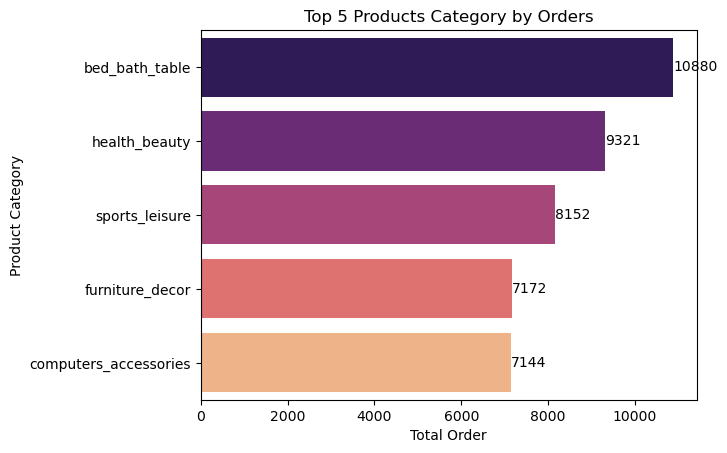

In [38]:
# Group by top 5 products category by Total Order
products_by_order = work_dataset.groupby('product_category_name').count()[['order_id']].sort_values(by='order_id', ascending=False).reset_index()[:5]

# Generates a bar plot
product_category_order = sns.barplot(data=products_by_order, x='order_id', y='product_category_name', palette='magma')

# Assign the bar values to each bar
product_category_order.bar_label(product_category_order.containers[0])

product_category_order.set_title("Top 5 Products Category by Orders", fontdict={'fontsize':12})
product_category_order.set_xlabel("Total Order", fontdict={'fontsize':10})
product_category_order.set_ylabel("Product Category")

# Show the plot
plt.show()


### 2. Top 5 products category by revenue.

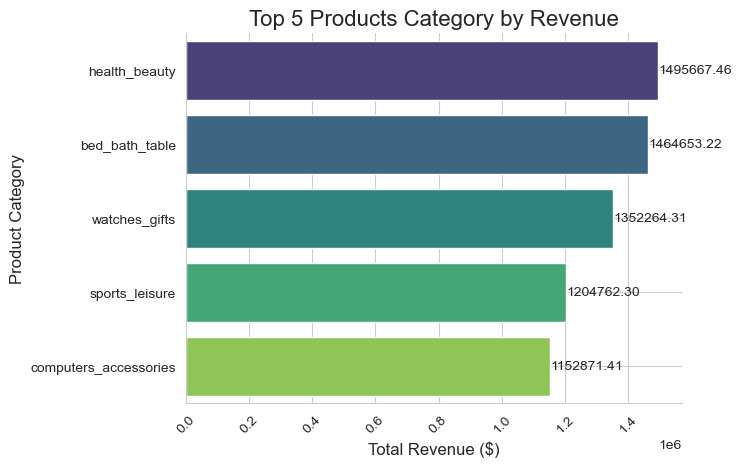

In [64]:
# Group by top 5 products category by Total Revenue
product_by_payment_value = work_dataset.groupby('product_category_name')['payment_value'].sum().sort_values(ascending=False).head(5).reset_index()

# Generates a bar plot
product_category_revenue = sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name', palette='viridis')

# Assign the bar values to each bar
for container in product_category_revenue.containers:
    product_category_revenue.bar_label(container, label_type='edge', fmt='%.2f')

product_category_revenue.set_title("Top 5 Products Category by Revenue", fontsize=16)
product_category_revenue.set_xlabel("Total Revenue ($)", fontsize=12)
product_category_revenue.set_ylabel("Product Category", fontsize=12)

# Improve aesthetics and layout
sns.set_style("whitegrid")
product_category_revenue.grid(axis='y')
product_category_revenue.spines['top'].set_visible(False)
product_category_revenue.spines['right'].set_visible(False)

# Rotate x-labels for better readability
product_category_revenue.tick_params(axis='x', labelrotation=45)

plt.show()


### 3. Sales trends based on time period.

In [40]:
# Create a new column 'month_year' in the DataFrame.
work_dataset['month_year'] = work_dataset['order_purchase_timestamp'].dt.strftime('%Y-%m')
work_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105692 entries, 0 to 116575
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       105692 non-null  object        
 1   order_status                   105692 non-null  object        
 2   order_purchase_timestamp       105692 non-null  datetime64[ns]
 3   order_estimated_delivery_date  105692 non-null  object        
 4   product_id                     105692 non-null  object        
 5   seller_id                      105692 non-null  object        
 6   price                          105692 non-null  float64       
 7   freight_value                  105692 non-null  float64       
 8   product_photos_qty             105692 non-null  int32         
 9   payment_sequential             105692 non-null  int32         
 10  payment_type                   105692 non-null  object        
 11  

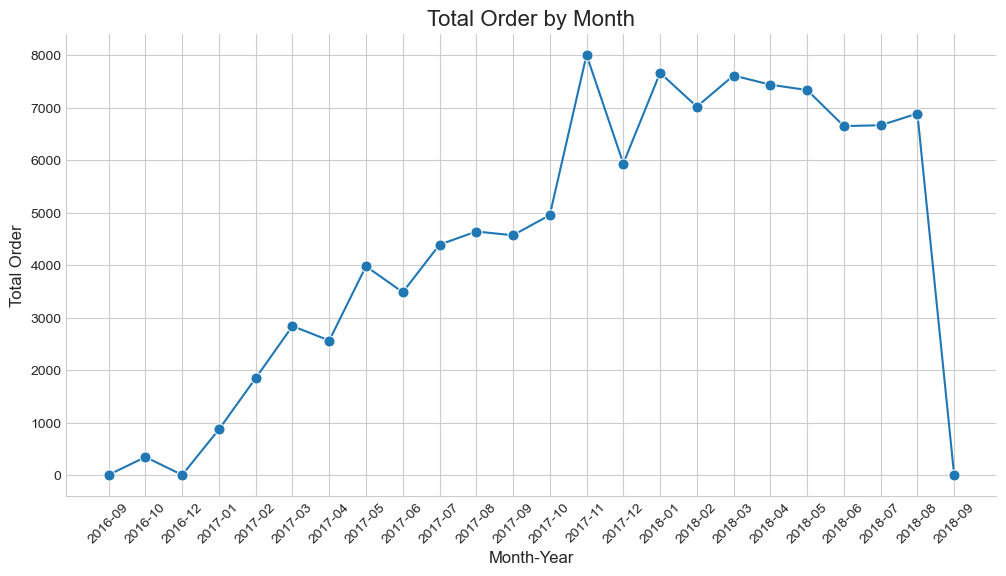

In [60]:
# Group dataset by order.
order_per_month = work_dataset.groupby(['month_year']).count()[['order_id']]

# Set up figure and axis
fig, sales_trend_plot = plt.subplots(figsize=(12, 6))
sns.lineplot(data=order_per_month, marker='o', markersize=8, color='red', label='Total Order', ax=sales_trend_plot)

# Title and labels
sales_trend_plot.set_title('Total Order by Month', fontsize=16)
sales_trend_plot.set_xlabel('Month-Year', fontsize=12)
sales_trend_plot.set_ylabel('Total Order', fontsize=12)

# Remove legend
sales_trend_plot.get_legend().remove()

# Grid lines and style
sales_trend_plot.grid(True)
sns.set_style("whitegrid")

# Spines style
sales_trend_plot.spines['top'].set_visible(False)
sales_trend_plot.spines['right'].set_visible(False)

# Ticks style
sales_trend_plot.tick_params(axis='both', which='both', length=0)
sales_trend_plot.tick_params(axis='x', rotation=45)

plt.show()


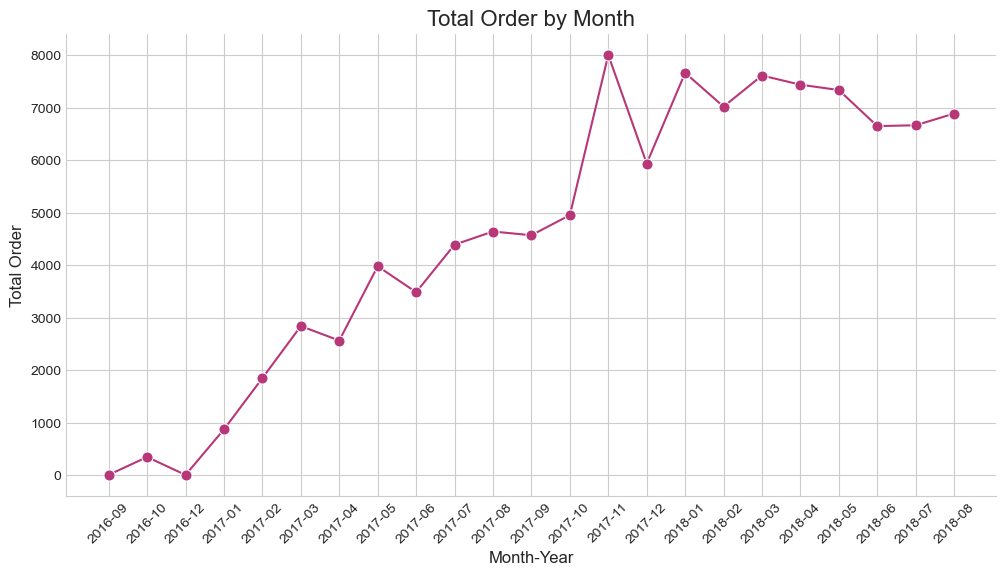

In [67]:
# Group dataset by order.
order_per_month = work_dataset.groupby(['month_year']).count()[['order_id']]

# Exclude last month data because only one record was found.
order_per_month = order_per_month.iloc[:-1]

# Set up figure and axis
fig, sales_trend_plot = plt.subplots(figsize=(12, 6))
sns.lineplot(data=order_per_month, marker='o', markersize=8, palette='magma', label='Total Order', ax=sales_trend_plot)

# Title and labels
sales_trend_plot.set_title('Total Order by Month', fontsize=16)
sales_trend_plot.set_xlabel('Month-Year', fontsize=12)
sales_trend_plot.set_ylabel('Total Order', fontsize=12)

# Remove legend
sales_trend_plot.get_legend().remove()

# Grid lines and style
sales_trend_plot.grid(True)
sns.set_style("whitegrid")

# Spines style
sales_trend_plot.spines['top'].set_visible(False)
sales_trend_plot.spines['right'].set_visible(False)

# Ticks style
sales_trend_plot.tick_params(axis='both', which='both', length=0)
sales_trend_plot.tick_params(axis='x', rotation=45)

plt.show()


### 4. Total order by payment method.  


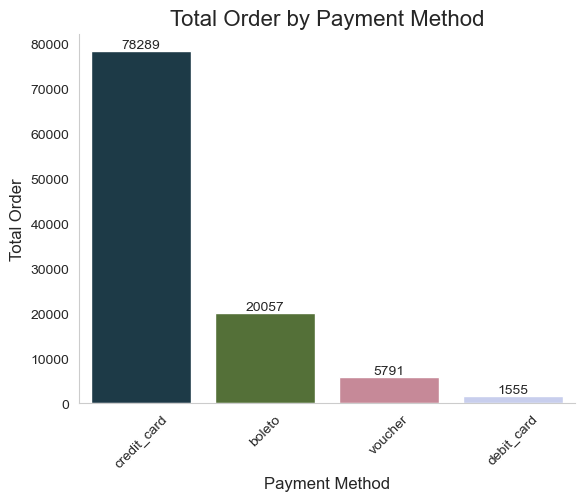

In [72]:
# Plot countplot [0]
payment_method_plot = sns.countplot(data=work_dataset, x="payment_type", palette="cubehelix")

# Assign bar values and enhance their labels
for container in payment_method_plot.containers:
    payment_method_plot.bar_label(container, label_type='edge', fmt='%.0f')

payment_method_plot.set_title('Total Order by Payment Method', fontsize=16)
payment_method_plot.set_xlabel('Payment Method', fontsize=12)
payment_method_plot.set_ylabel('Total Order', fontsize=12)

# Improve aesthetics and layout
sns.set_style("whitegrid")
payment_method_plot.grid(axis='y')
payment_method_plot.spines['top'].set_visible(False)
payment_method_plot.spines['right'].set_visible(False)

# Rotate x-labels for better readability
payment_method_plot.tick_params(axis='x', labelrotation=45)

plt.show()


### 5. Distribution of review scores.  

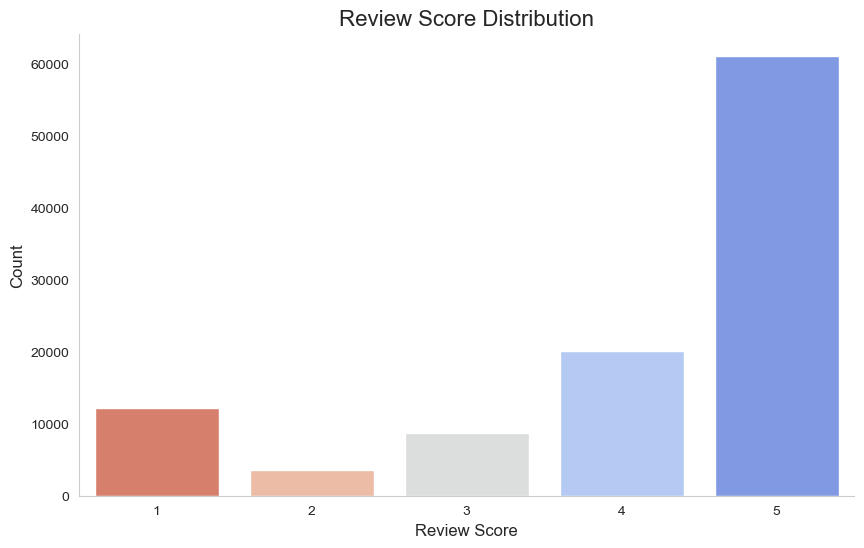

In [75]:
# Create subplots size 10,6
fig, review_scores_plot = plt.subplots(figsize=(10,6))

# Plot countplot
review_scores_plot = sns.countplot(data=work_dataset, x="review_score", palette="coolwarm_r")

# Assign bar values and enhance their labels
for container in ax.containers:
    review_scores_plot.bar_label(container, label_type='edge', fmt='%.0f')

review_scores_plot.set_title('Review Score Distribution', fontsize=16)
review_scores_plot.set_xlabel('Review Score', fontsize=12)
review_scores_plot.set_ylabel('Count', fontsize=12)

# Improve aesthetics and layout
sns.set_style("whitegrid")
review_scores_plot.grid(axis='y')
review_scores_plot.spines['top'].set_visible(False)
review_scores_plot.spines['right'].set_visible(False)

# Rotate x-labels for better readability
review_scores_plot.tick_params(axis='x', labelrotation=0)

plt.show()
